In [25]:
import os
import numpy as np
import pandas as pd

from subprocess import Popen, check_output, PIPE
from multiprocessing import Pool

from textwrap import wrap

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

In [26]:
mpl.rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 
                     'axes.titlesize':14, 'axes.labelsize':16}) #default font sizes for plots

In [6]:
work_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/SysGen2023/data/' #output dur for results

In [7]:
eqtl_dir = '/lustre/groups/epigenereg01/workspace/public_data/lappalainen-2013/eqtl/' #eQTL data for 1000g Phase1

In [8]:
Phase3_dir = '/lustre/groups/epigenereg01/workspace/public_data/1000genomes/Phase3/' #1000g Phase3

#Phase1_dir = '/lustre/groups/epigenereg01/workspace/public_data/1000genomes/Phase1/' #1000g Phase1

# Data Analysis

In [9]:
eqtl_df = pd.read_csv(eqtl_dir + 'EUR373.gene.cis.FDR5.all.rs137.txt.gz', sep='\t') #eQTL calls

In [10]:
pvalue_thr = 1e-12 #stringent threshold, same as used in our RECOMB paper

#select eQTLs according to the p-value threshold
eqtl_filtered = eqtl_df[(eqtl_df.pvalue<pvalue_thr)&(eqtl_df.CHR_SNP==eqtl_df.CHR_GENE)] 

In [11]:
eqtl_filtered.GENE_ID.nunique() #total genes studied

1042

In [12]:
#How many eQTLs does each gene have?
snp_per_gene = eqtl_filtered.groupby('GENE_ID').size().sort_values(ascending=False)

<Axes: xlabel='GENE_ID'>

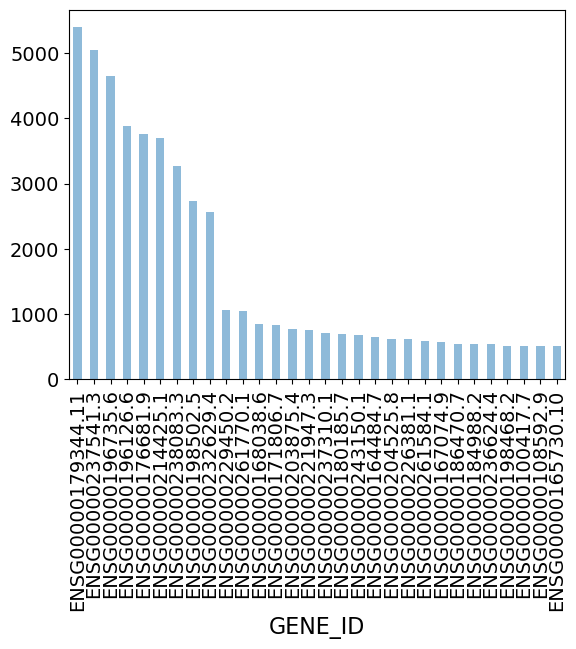

In [29]:
snp_per_gene.head(30).plot(kind='bar', alpha=0.5)

<Axes: >

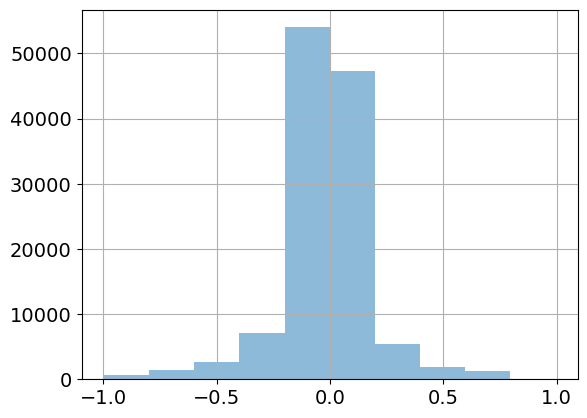

In [31]:
#relative position of eQTL w.r.t. TSS of the regulated gene

snp_pos_rel = eqtl_filtered.SNPpos-eqtl_filtered.TSSpos

(snp_pos_rel/1e6).hist(alpha=0.5)

In [15]:
print(np.percentile(snp_pos_rel,[5,95]))
print(np.percentile(snp_pos_rel,[1,99]))

[-324475.5  257044.5]
[-691324.4   600629.95]


In [16]:
#genes_tss['start'] = genes_tss.TSSpos - 700_000
#genes_tss['stop'] = genes_tss.TSSpos + 700_000
#genes_tss['strand'] = '.'
#genes_tss['score'] = 0
#genes_tss[['CHR_GENE','start','stop','GENE_ID','score','strand']].to_csv(data_dir + 'selected_genes.bed',sep='\t',header=None)

We will now investigate the minor allele frequency (MAF) distribution for the eQTL variants. For each variant, we will use its ID starting with rs... to query its 1000 Genomes MAF value in the dbSNP database (CAF field in the INFO column). It's faster than looping aroung all 1000 Genomes chromosomes. 

In [17]:
eQTL_ids_txt = work_dir + 'eQTL_ids.txt'

In [18]:
eqtl_filtered.sort_values(by=['CHR_SNP', 'SNPpos']).SNP_ID.to_csv(eQTL_ids_txt,header=None, index=None)

In [19]:
dbSNP_vcf = '/lustre/groups/epigenereg01/workspace/projects/vale/tools/dbSNP/GRCh37/00-All.GRCh37.vcf.gz'

In [20]:
#query dbSNP based on list of SNPs IDs
AF_pipe = Popen(f'bcftools view  -i "ID=@{eQTL_ids_txt}" {dbSNP_vcf}| bcftools query -f "%CAF\n" ', shell=True, stdout=PIPE)

MAF = []

for AF in AF_pipe.stdout:
    AF = AF.decode("utf-8").split(',')
    if len(AF)==2: #only biallelic variants
        MAF.append(min(float(AF[0]),float(AF[1])))

(array([1877., 4870., 5364., 6537., 6109., 6490., 6705., 6795., 6228.,
        6648.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 10 artists>)

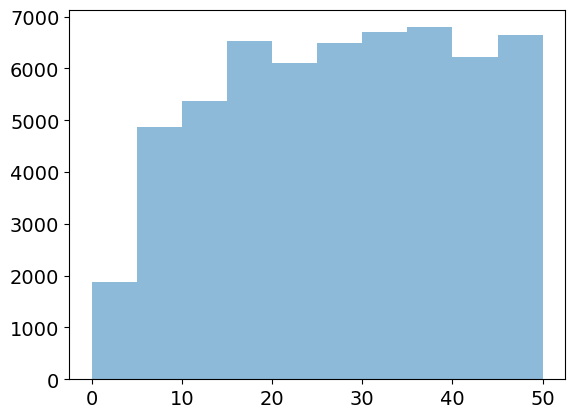

In [28]:
plt.hist(np.array(MAF)*100, alpha=0.5)

In [94]:
np.percentile(MAF,[1,5])

array([0.03295, 0.0641 ])

let's choose 3% (0.03) as minimal MAF

# Extract genotypes

In [1]:
MIN_MAF = 0.03 #1st percentile of known eQTLs

CHUNK_SIZE = 5000 #corresponds to a 2Mbp region around the TSS, should be enough

In [123]:
dataset_name = 'phase3_top100'

MAX_GENES = 100 #limit the number of genes for experimental datasets

In [124]:
dataset_dir = work_dir + '/new/' + dataset_name + '/'

os.makedirs(dataset_dir, exist_ok=True)

In [125]:
def extract_region_gt(gene_id, vcf, chrom, tss_pos, size=2_000_000, 
                      crop_around_tss=False, selected_gt_df=None, selected_samples=None):
    
    # encoding for 1000g genotypes: reference, farther, mother, both (homozygous)
    # designation of heterozygous variants as farther and mother is arbitrary 
    GT_encoding = {'0|0':'R','0|1':'F','1|0':'M','1|1':'B'} 

    if selected_samples is not None:
        selected_samples = ','.join(selected_samples)
        select_samples_cmd = f'--force-samples -s "{selected_samples}"' #samples parameter for bcftools command
    else:
        select_samples_cmd = ''
        
    #select only biallelic SNPs, passing all filters, with alternative allele frequency above MIN_MAF
    vcf_chunk = Popen(
        f'bcftools view  --max-alleles 2 -f "PASS" -v "snps" -i "AF>{MIN_MAF}&AF<{1-MIN_MAF}" \
        {vcf} {chrom}:{max(tss_pos-size//2,0)}-{tss_pos+size//2} | \
        bcftools query  -H -f "%CHROM %POS %ID %REF %ALT %AF [%GT ]\n" ', shell=True, stdout=PIPE)
    
    chunk_GT = [] #all genotypes in the queried region
    
    nonsample_columns = 6 #chrom,pos,id,ref,alt,AF
    
    for idx, line in enumerate(vcf_chunk.stdout):
        line = line.decode('utf-8').strip()
        if idx==0:
            #first row is the header
            #remove column index from column name
            header = ['chrom', 'pos', 'id', 'ref', 'alt', 'AF'] + [column[column.find(']')+1:].replace(':GT','') for column in line[2:].split()[nonsample_columns:]]
        else:
            #any other row corresponds to a single SNP
            GT_row = line.split() #genotypes for all individuals for a given variant
            #map phased genotypes to single letters
            GT_row = GT_row[:nonsample_columns] + [GT_encoding.get(GT,'N') for GT in GT_row[nonsample_columns:]]
            chunk_GT.append(GT_row)

    chunk_GT = pd.DataFrame(chunk_GT,columns=header)
    
    chunk_GT.pos = chunk_GT.pos.astype(int)

    #if selected_gt_df is not None:
    #    #only select positions from selected_gt_df, 
    #    #missing positions will be filled with NaNs
    #    #this ensures exact position matching between train and test sets
    #    chunk_GT = chunk_GT.merge(selected_gt_df, how='right')
    #    
    #    chunk_GT.AF = chunk_GT.AF.fillna(0.).astype(float)
    #    chunk_GT.iloc[:,nonsample_columns:] = chunk_GT.iloc[:,nonsample_columns:].fillna('N')

    if crop_around_tss:
        #the number of variants is limited by CHUNK_SIZE
        #if we have more variants, we crop upstream or downstream, s.t. the TSS remains approximately in the middle of the chunk
        
        tss_idx = np.searchsorted(chunk_GT.pos,tss_pos) #bcftools result is normally sorted by position, so we can use searchsorted
    
        N_vars_init = len(chunk_GT) #initial number of variants in the queried region, keep for statistics
        
        if tss_idx<CHUNK_SIZE//2:
            #start of the region, cut upstream
            chunk_GT = chunk_GT.iloc[:CHUNK_SIZE]
        elif tss_idx>CHUNK_SIZE//2:
            if tss_idx + CHUNK_SIZE//2<=len(chunk_GT):
                #in the middle of the region, center around TSS
                chunk_GT = chunk_GT.iloc[tss_idx-CHUNK_SIZE//2:tss_idx+CHUNK_SIZE//2]
            else:
                #end of the region, cut downstream
                chunk_GT = chunk_GT.iloc[max(len(chunk_GT)-CHUNK_SIZE,0):]

    #convert genotypes for all individuals at a given position to a string
    genotypes = chunk_GT.iloc[:,nonsample_columns:].sum().reset_index().rename(columns={0:'seq','index':'sample_id'})
    
    meta = chunk_GT.iloc[:,:nonsample_columns] #chrom,pos,id,ref,alt,AF
    
    if crop_around_tss:
        meta['initial_counts'] = N_vars_init #for statistics only

    genotypes['GENE_ID'] = gene_id
    meta['GENE_ID'] = gene_id

    meta['seq_idx'] = range(len(meta))
    
    return genotypes, meta

In [144]:
#info about TSS position of each gene

genes_tss = eqtl_filtered[['GENE_ID','CHR_GENE','TSSpos']].drop_duplicates().set_index('GENE_ID')

genes_tss.TSSpos = genes_tss.TSSpos.astype(int)
genes_tss.CHR_GENE = genes_tss.CHR_GENE.astype(str)

print(f'Selected genes: {MAX_GENES}/{len(genes_tss)}')

genes_tss = genes_tss.loc[snp_per_gene.index].iloc[:MAX_GENES]

Selected genes: 100/1042


In [127]:
#def extract_gt_test_wrapper(args):
#
#    gene_id, (chrom, tss_pos) = args
#
#    #vcf from 1000g Phase1
#    chrom_vcf = Phase1_dir + f'ALL.chr{chrom}.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.vcf.gz'
#
#    gene_GT, gene_meta = extract_region_gt(gene_id, chrom_vcf, chrom, tss_pos, crop_around_tss=False,
#                                          selected_gt_df = train_meta[train_meta.GENE_ID==gene_id][['chrom','pos','ref','alt']],
#                                          selected_samples = test_samples)
#
#    print(f'genotypes for {gene_id} collected')
#
#    return gene_GT, gene_meta
#
def extract_gt_wrapper(args):

    gene_id, (chrom, tss_pos) = args

    #vcf from 1000g Phase3
    chrom_vcf = Phase3_dir + f'ALL.chr{chrom}.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz'

    gene_GT, gene_meta = extract_region_gt(gene_id, chrom_vcf, chrom, tss_pos, crop_around_tss=True)

    print(f'genotypes for {gene_id} collected')

    return gene_GT, gene_meta

In [128]:
def run_pool(extract_gt_fcn):
    
    pool = Pool(processes=8, maxtasksperchild=5)

    all_res = list(tqdm(pool.imap_unordered(extract_gt_fcn, genes_tss.iterrows()), total=len(genes_tss)))
     
    pool.close()
    pool.join()

    all_GT, all_meta = zip(*all_res)

    all_GT = pd.concat(all_GT)
    all_meta = pd.concat(all_meta)

    return all_GT, all_meta

In [129]:
# use multiprocessing to quickly extract genotypes for all genes

all_GT, all_meta = run_pool(extract_gt_wrapper)

  0%|          | 0/100 [00:00<?, ?it/s]

genotypes for ENSG00000238083.3 collected
genotypes for ENSG00000176681.9 collected
genotypes for ENSG00000214425.1 collected
genotypes for ENSG00000229450.2 collected
genotypes for ENSG00000261770.1 collected
genotypes for ENSG00000198502.5 collected
genotypes for ENSG00000237541.3 collected
genotypes for ENSG00000196126.6 collected
genotypes for ENSG00000179344.11 collectedgenotypes for ENSG00000196735.6 collected

genotypes for ENSG00000168038.6 collected
genotypes for ENSG00000232629.4 collected
genotypes for ENSG00000171806.7 collected
genotypes for ENSG00000221947.3 collected
genotypes for ENSG00000237310.1 collected
genotypes for ENSG00000243150.1 collected
genotypes for ENSG00000203875.4 collected
genotypes for ENSG00000180185.7 collected
genotypes for ENSG00000261584.1 collected
genotypes for ENSG00000164484.7 collected
genotypes for ENSG00000167074.9 collected
genotypes for ENSG00000186470.7 collected
genotypes for ENSG00000184988.2 collected
genotypes for ENSG00000226381.1 c

In [130]:
#test samples are individuals, for which expression is available
patients_df = pd.read_csv(eqtl_dir + 'patients.txt', sep='\t',usecols=[0,1,2,3])
test_samples = patients_df.loc[patients_df.super_pop=='EUR', 'sample'].values

In [131]:
#mark train/val samples in the genotype dataframe
#samples = samples[~samples.isin(test_samples)].sample(frac=1., random_state=1).tolist() #shuffle samples, to make a random split
#train_samples = samples[:int(0.8*len(samples))]
#val_samples = samples[int(0.8*len(samples)):]
#all_GT.loc[all_GT.sample_id.isin(val_samples), 'split'] = 'val'
#all_GT.loc[all_GT.sample_id.isin(train_samples), 'split'] = 'train'

all_GT.loc[all_GT.sample_id.isin(test_samples), 'split'] = 'test'
all_GT.split = all_GT.split.fillna('train')

#shuffle and sort by split
all_GT = all_GT.sample(frac=1., random_state=1).sort_values(by='split', ascending=False)

/tmp/ipykernel_3327675/1588842342.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'test' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  all_GT.loc[all_GT.sample_id.isin(test_samples), 'split'] = 'test'


In [133]:
all_GT.index = all_GT.split + ':' + all_GT.sample_id + ':' + all_GT.GENE_ID
all_GT.index.name = 'seq_name'

In [136]:
all_GT[['seq']].to_parquet(dataset_dir + 'dataset.parquet')

In [137]:
all_meta.to_csv(dataset_dir + 'meta.csv.gz', index=None)

In [132]:
#def write_fasta(fasta_path, seq_df):
#
#    print(f'Writing sequences to {fasta_path}')
#
#    with open(fasta_path, 'w') as f:
#        for seq_header, seq in tqdm(seq_df.seq.items(),total=len(seq_df)):
#            f.write(f'>{seq_header}\n')
#            for line in wrap(seq, 80): #wrap sequence with standard FASTA width
#                f.write(line+'\n')

In [ ]:
#write_fasta(dataset_dir + 'dataset.fa', all_GT)

In [135]:
#! samtools faidx {dataset_dir + 'dataset.fa'}

# Covered genomic distance

In [99]:
meta_df = pd.read_csv('/lustre/groups/epigenereg01/workspace/projects/vale/PRS/SysGen2023/data/phase3_top100/meta.csv')

In [117]:
length_bp = meta_df.groupby('GENE_ID').apply(lambda x:int((x.pos.max()-x.pos.min())/1000)).rename('length(Kb)')

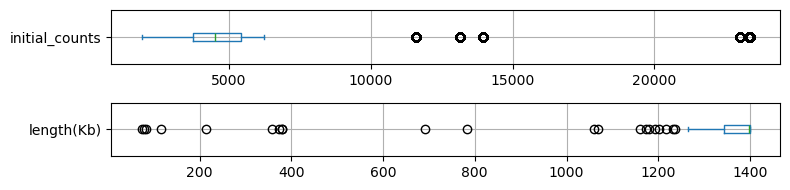

In [118]:
fig, axes = plt.subplots(2,1,figsize=(8,2))

meta_df.initial_counts.plot(kind='box', vert=False,ax=axes[0])
axes[0].grid(True)

length_bp.plot(kind='box', vert=False,ax=axes[1])
axes[1].grid(True)

fig.tight_layout()